# Confusion Matrix diff Custom, Fine tune

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import random
from PIL import Image

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
download_dir = Path('/content/drive/MyDrive/SkinDiseases') #need to change your path

In [ ]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'

class_subset = sorted(os.listdir('/content/drive/MyDrive/SkinDiseases/test'))[:11] # Using only the first 11 classes #need to change your path

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 9235 images belonging to 11 classes.
Found 1624 images belonging to 11 classes.
Found 1561 images belonging to 11 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    # top_model = Dense(11, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=11

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model with Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

In [ ]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=5,
                            validation_data=validgen,
                            steps_per_epoch=140,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

# **Check later**

In [ ]:
from keras.models import load_model

scratch_model = load_model('/content/tl_model_v1.h5')

scratch_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Loading predictions from last article's model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'test',
                                             target_size=(224, 224),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

scratch_preds = scratch_model.predict(testgen)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

scratch_acc = accuracy_score(true_classes, scratch_pred_classes)
print("From Scratch Model Accuracy with Fine-Tuning: {:.2f}%".format(scratch_acc * 100))

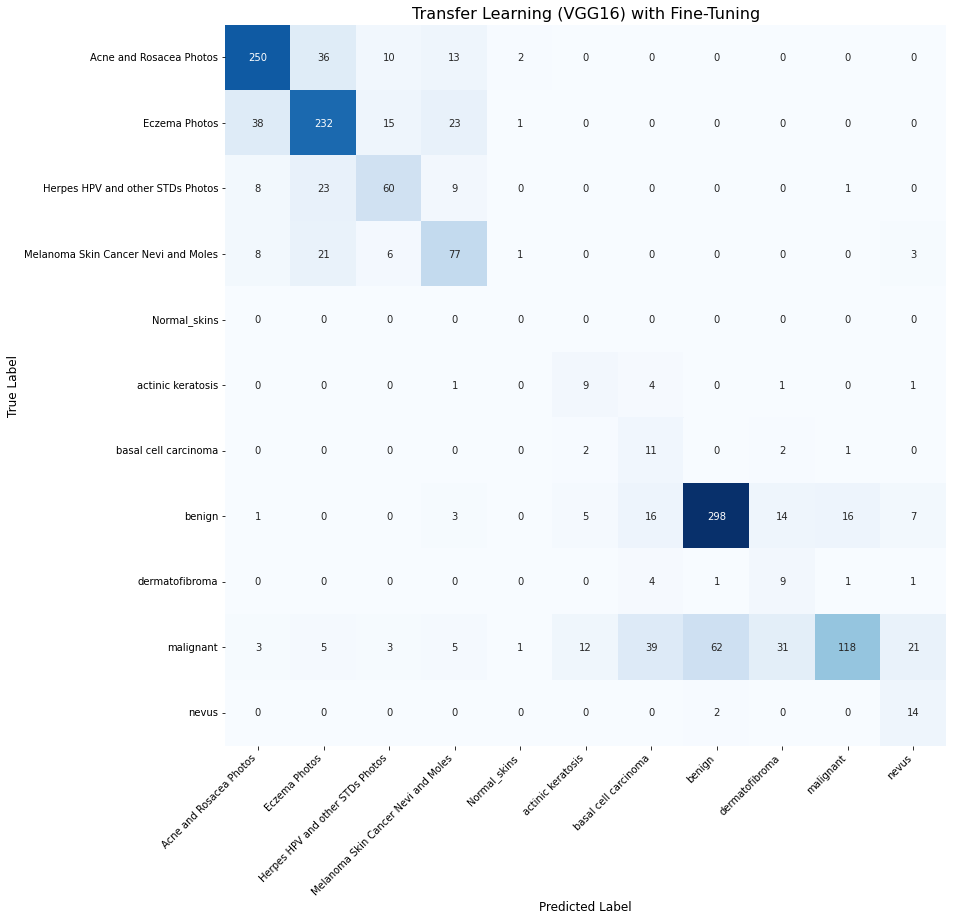

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(1, 1, figsize=(20, 10))
    
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) with Fine-Tuning")       

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes,vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       311
           1       0.73      0.75      0.74       309
           2       0.64      0.59      0.62       101
           3       0.59      0.66      0.62       116
           4       0.00      0.00      0.00         0
           5       0.32      0.56      0.41        16
           6       0.15      0.69      0.24        16
           7       0.82      0.83      0.82       360
           8       0.16      0.56      0.25        16
           9       0.86      0.39      0.54       300
          10       0.30      0.88      0.44        16

    accuracy                           0.69      1561
   macro avg       0.49      0.61      0.50      1561
weighted avg       0.76      0.69      0.70      1561



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
TP = cm.diagonal()

precision_micro = TP.sum()/cm.sum()
recall_micro = TP.sum()/cm.sum()

precision_macro = np.nanmean(TP/cm.sum(0))
recall_macro = np.nanmean(TP/cm.sum(1))

print("")
print("Calculated:")
print("precision_micro:", precision_micro)
print("precision_macro:", precision_macro)
print("recall_micro:", recall_micro)
print("recall_macro:", recall_macro)


Calculated:
precision_micro: 0.6905829596412556
precision_macro: 0.4888844043077587
recall_micro: 0.6905829596412556
recall_macro: 0.6721131202888976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
f1 = (2*precision_macro*recall_macro)/(recall_macro+precision_macro)

print("F1 macro:",f1)

F1 macro: 0.5660401774827574


In [ ]:
#predict_y = vgg_model.predict(testgen)
# predict_value = []
# for predict in vgg_preds:
#   if (predict>0.5).all():
#     predict_value.append(1)
#   else:
#     predict_value.append(0)
# from sklearn.metrics import confusion_matrix
# conmatrix = confusion_matrix(true_classes,vgg_pred_classes)
# import seaborn as sns
# sns.heatmap(cm, annot=True,cmap="Blues",fmt="d",cbar=True,annot_kws={"size": 10})

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(true_classes,vgg_pred_classes))

#**download trained model**

In [ ]:
import tensorflow as tf
saved_model_path = "saved_model/SkinDisease"
!mkdir -p saved_model
tf.saved_model.save(vgg_model, saved_model_path)

INFO:tensorflow:Assets written to: saved_model/SkinDisease/assets


In [ ]:
!mkdir "tflite_model"
TFLITE_MODEL = "tflite_model/SkinDisease.tflite"
modell = tf.saved_model.load(saved_model_path)
concrete_func = modell.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 224, 224, 3])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

65295404

In [ ]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(vgg_model, export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1649352828/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1649352828/assets


'/tmp/saved_models/1649352828'

In [ ]:
from importlib import reload
MODEL_NAME = "resnet_vgg_mix.h5"
vgg_model.save(MODEL_NAME)

In [ ]:
import os
from google.colab import files
print( os.getcwd() )
files.download( "/content/tflite_model/SkinDisease.tflite" )
files.download( "/content/resnet_vgg_mix.h5" )
files.download( "/content/tl_model_v1.h5" )